In [61]:
import os
import csv
from sparta.Auxil.PeriodicityDetector import PeriodicityDetector
from sparta.UNICOR.Spectrum import Spectrum
from sparta.UNICOR.Template import Template
from sparta.Auxil.TimeSeries import TimeSeries
from sparta.Observations import Observations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import sparta.Statistics as stat
import copy as cp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [103]:
def cut_observations(observations, start, end):
    """
    Cut the observations to the given time interval.
    :param observations: Observations object
    :param start: start time in BJD
    :param end: end time in BJD
    :return: Observations object
    """
    new_times = []
    new_vals = []
    new_air_mass = []
    new_rv = []
    observations_cut = observations
    for j, y in enumerate(observations_cut.time_series.times):
        if (y >= start) and (y <= end):
            new_times.append(observations_cut.time_series.times[j])
            new_vals.append(observations_cut.time_series.vals[j])
            new_air_mass.append(observations_cut.air_mass[j])
            new_rv.append(observations_cut.time_series.calculated_vrad_list[j])
    observations_cut.time_series.calculated_vrad_list = new_rv
    observations_cut.time_series.times = new_times
    observations_cut.time_series.vals = new_vals
    observations_cut.air_mass = new_air_mass
    observations_cut.sample_size = len(observations.time_series.vals)
    observations_cut.time_series.size = observations.sample_size
    observations_cut.spec_list = observations.time_series.vals
    return observations_cut

### Test the minimal number of observations required to get a peak with del Cep.

In [142]:
# DATA PARAMETERS

survey = "HERMES" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 4850 # minimum wavelength of the data
max_wv = 4870 # maximum wavelength of the data
spec_dir = r'C:\Users\kentb\Desktop\PDM\data\Hermes\delCep_Hermes_spectra'  # directory of the spectra
rv_dir = r'C:\Users\kentb\Desktop\PDM\data\RV\delCep_rv.csv' #rv_folder  # directory of the RVs

# LOAD DATA

obs_data = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,
                        target_visits_lib=spec_dir)
df = pd.read_csv(rv_dir)
rv = df.rv.astype(float).values
e_rv = df.rv_err.astype(float).values
times = df.bjd.astype(float).values
if survey == "CORALIE":
    ids = df.unique_id.astype(str).values
elif survey == "HERMES":
    ids = df.unique_id.astype(int).values
# Preprocess the spectra
for i in obs_data.time_series.vals:
    if abs(min_wv-max_wv) >= 100:
        i = i.InterpolateSpectrum()
        i = i.FilterSpectrum(lowcut=3, highcut=0.15, order = 1)
        i = i.ApplyCosineBell(alpha=0.3)
    else:
        i = i.InterpolateSpectrum()
# Rearrange the RVs with the spectra
obs_data.rearrange_time_series(rv=rv, times=times,ids=ids)

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\data\Hermes\delCep_Hermes_spectra
Selected directory: C:\Users\kentb\Desktop\PDM\data\Hermes\delCep_Hermes_spectra
Matching ratio -> 89 %


In [179]:
print(np.min(obs_data.time_series.times), np.max(obs_data.time_series.times))
print(len(obs_data.time_series.times))
obs_data = cut_observations(obs_data, 58020, 58200)
print(len(obs_data.time_series.times))

25
21


In [180]:
# PERIODOGRAM PARAMETERS

baseline = np.max(obs_data.time_series.times) - np.min(obs_data.time_series.times) # baseline of the data
min_freq = 0.1 # Or maybe 1/2/baseline to be sure but let's test it that way.
max_freq = 0.5 # depends on the star.
freq_range = (min_freq, max_freq) # frequency range of the periodograms
points_per_peak = 30
periodogram_grid_resolution = 3000#points_per_peak*max_freq*baseline # frequency resolution of the periodograms

# RESULS DIRECTORY

results_dir = r'C:\Users\kentb\Desktop\PDM\thesis\main\periodicity_stability' # directory of the results

In [181]:
## Compute periodograms

# Choosing frequency range and frequency resolution for the periodograms.
obs_data.initialize_periodicity_detector(freq_range=freq_range,periodogram_grid_resolution=periodogram_grid_resolution)

obs_data.periodicity_detector.calc_GLS()

print("GLS done",flush=True)

obs_data.periodicity_detector.calc_PDC(calc_biased_flag=False, calc_unbiased_flag=True)

print("PDC done",flush=True)

obs_data.periodicity_detector.calc_USURPER(calc_biased_flag=False, calc_unbiased_flag=True)

print("USURPER done",flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shape")

print("Shape done",flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shift")

print("Shift done",flush=True)

GLS done
PDC done
USURPER done
Shape done
Shift done


In [182]:
# Save the observations instance in a csv file with the name of the spec_dir name in the results directory

with open(os.path.join(results_dir, f"{spec_dir.rsplit('/',maxsplit=1)[-1]}_{str(min_wv)}_{str(max_wv)}_{str(int(np.min(obs_data.time_series.times)))}_{str(int(np.max(obs_data.time_series.times)))}_{len(obs_data.time_series.times)}.csv"), 'w',newline='',encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["freq", "gls","usurper","pdc_unbiased","shape_periodogram", "shift_periodogram"])
    for i in range(len(obs_data.periodicity_detector.results_frequency['GLS'])):
        writer.writerow([obs_data.periodicity_detector.results_frequency['GLS'][i],
                        obs_data.periodicity_detector.results_power['GLS'][i],
                        obs_data.periodicity_detector.results_power['USURPER'][i],
                        obs_data.periodicity_detector.results_power['PDC_unbiased'][i],
                        obs_data.periodicity_detector.results_power['shape_periodogram'][i],
                        obs_data.periodicity_detector.results_power['shift_periodogram'][i]])

In [183]:
# Load data for all stars by looping through the directory
delCep_results = []
for filename in os.listdir('./delCep'):
    delCep_results.append(stat.open_csv('./delCep/'+filename))
    print(filename)

delCep_Hermes_spectra_4850_4870_55816_58146_263.csv
delCep_Hermes_spectra_4850_4870_56919_58146_137.csv
delCep_Hermes_spectra_4850_4870_57061_58146_123.csv
delCep_Hermes_spectra_4850_4870_57180_58146_109.csv
delCep_Hermes_spectra_4850_4870_57286_58146_61.csv
delCep_Hermes_spectra_4850_4870_57567_58146_55.csv
delCep_Hermes_spectra_4850_4870_57994_58146_29.csv
delCep_Hermes_spectra_4850_4870_58025_58146_21.csv


In [25]:
plt.style.use('sparta')

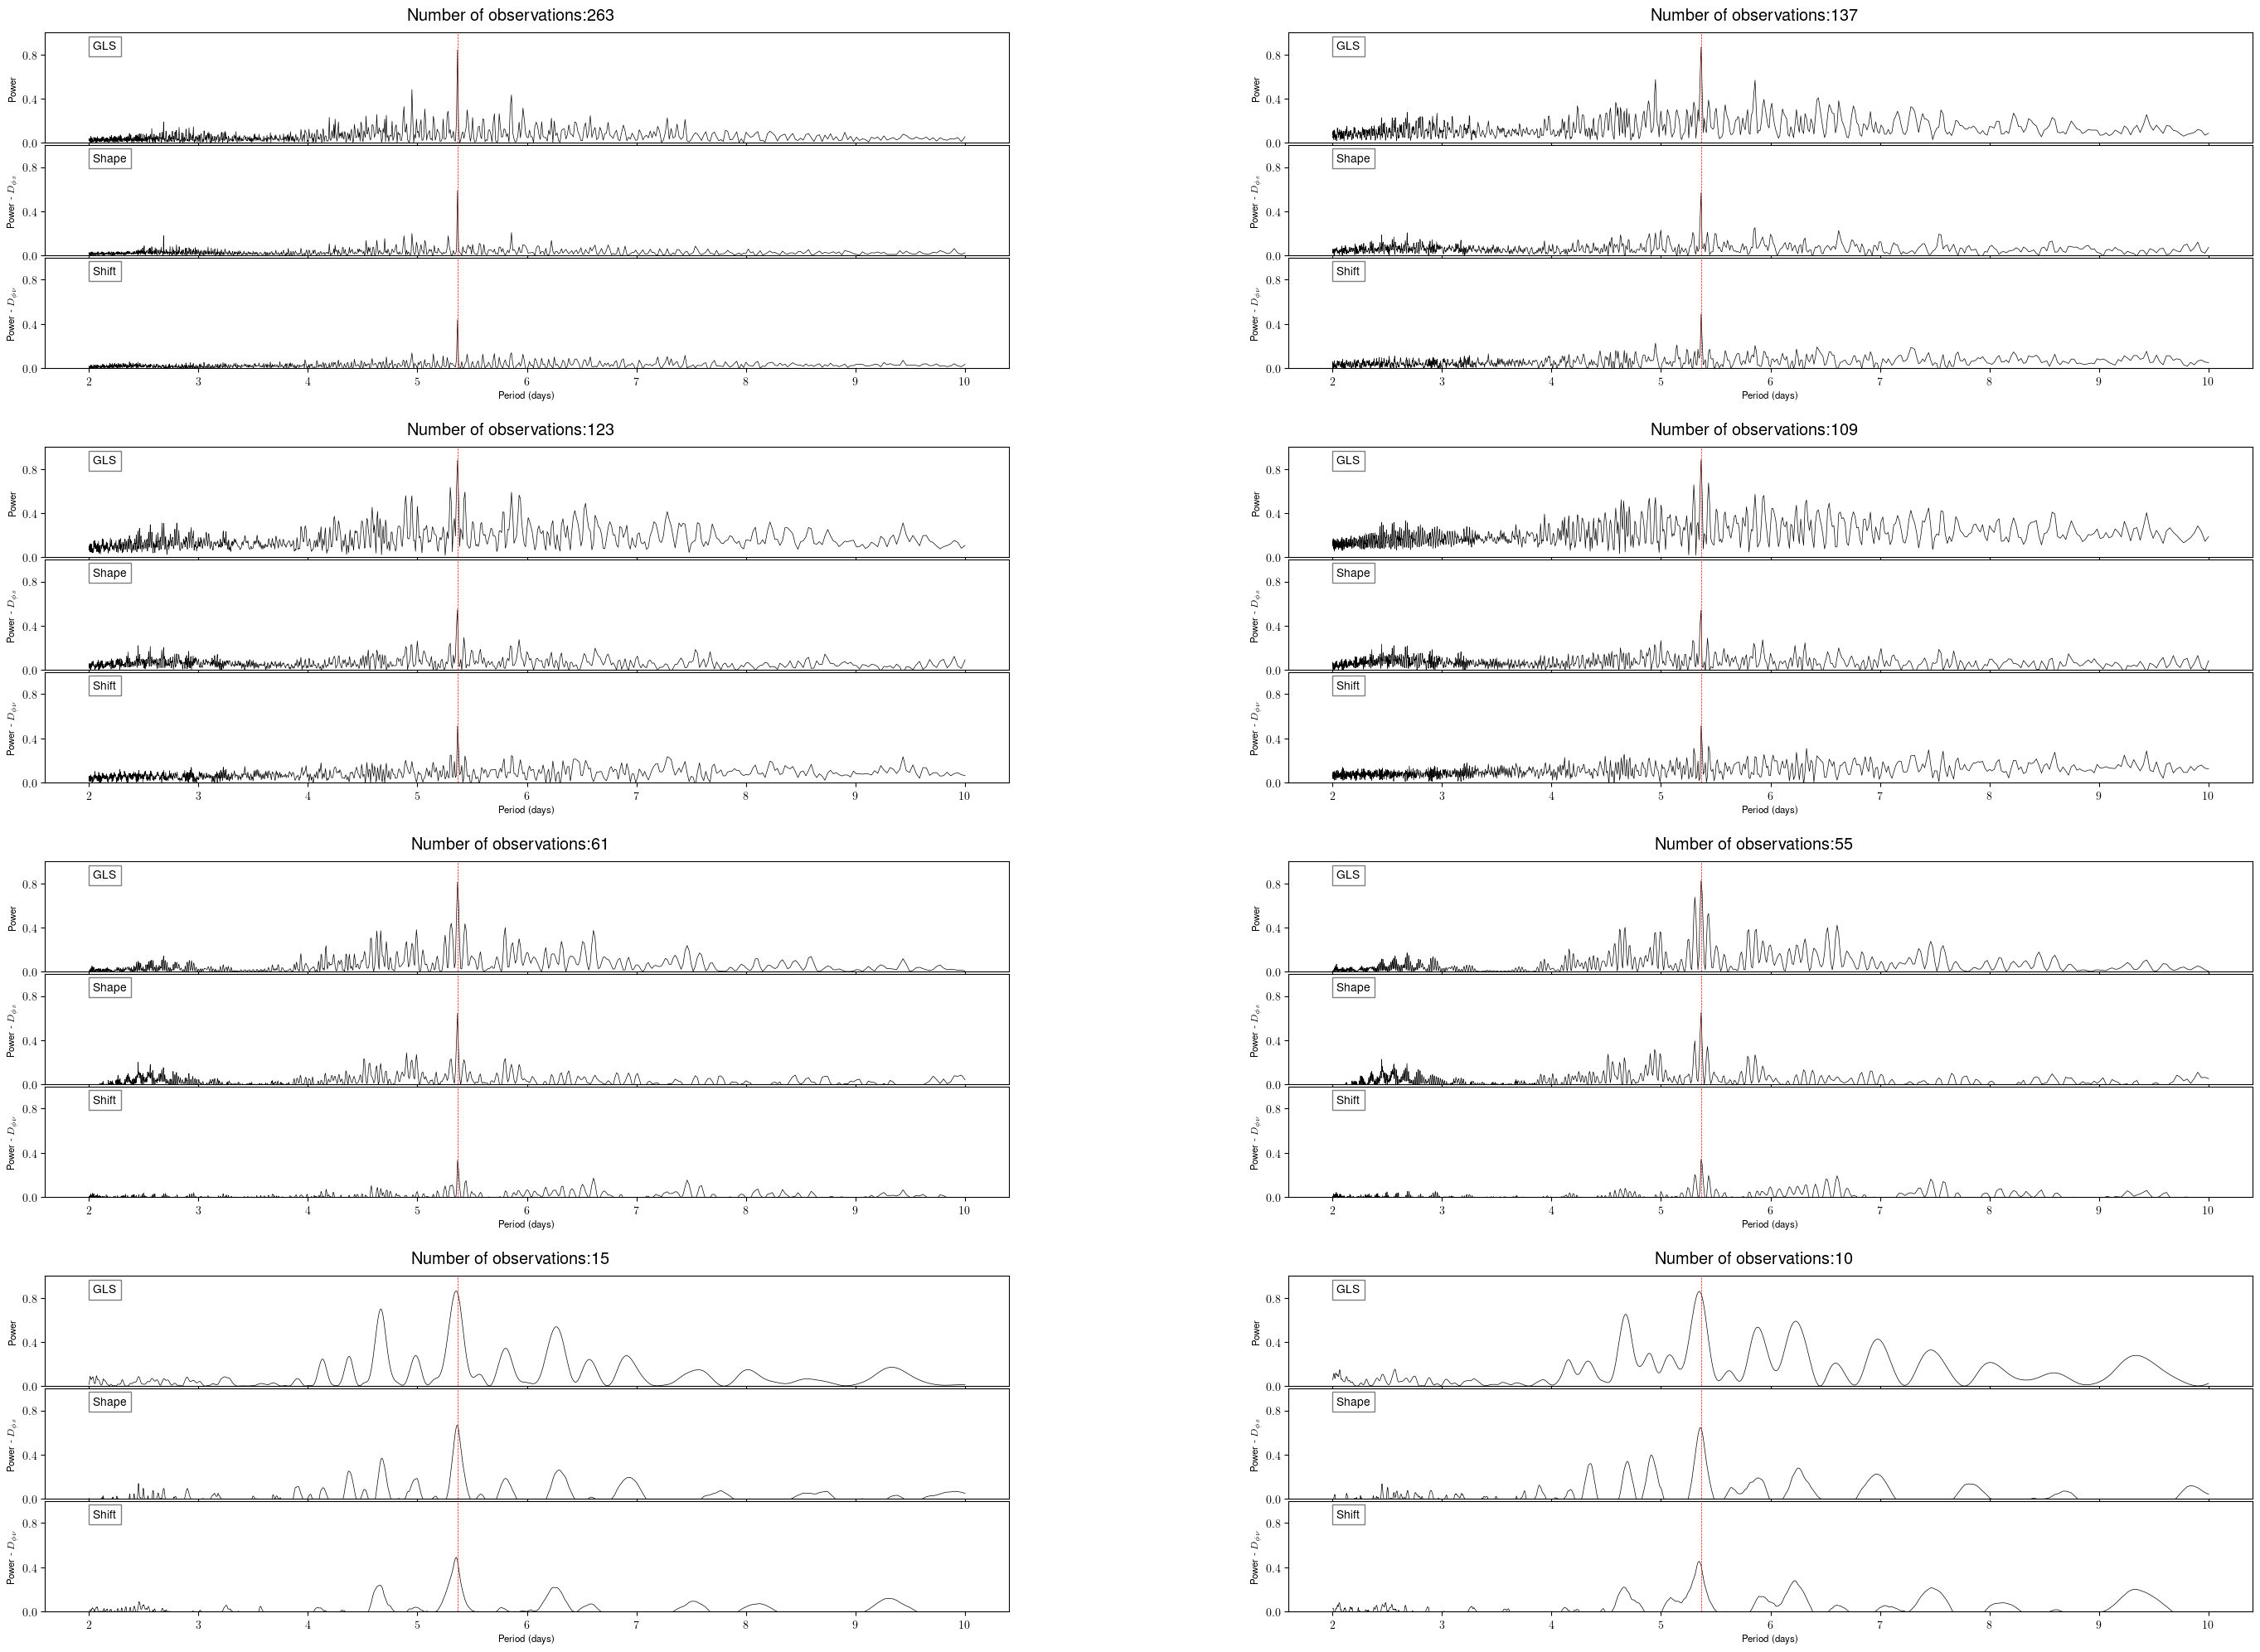

In [184]:
period_truth = 5.366267
n_obs = [263,137,123,109,61,55,15,10]
# Create a figure with 11 subfigures arranged in a 4*3 grid

fig = plt.figure(constrained_layout=False, figsize=(30, 20))
fig.suptitle(r'$\delta$ Cephei - Observations number', fontsize='x-large')

# plt.suptitle(r'$\delta$ Cephei - Tellurics Analysis', fontsize='x-large')

subfigs = fig.subfigures(4, 2)

for outerind, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(3, 1,sharex=True)
    subfig.suptitle(r'Number of observations:'+str(n_obs[outerind]), fontsize='x-large')
    for innerind, ax in enumerate(axs.flat):
        if innerind==0:
            ax.plot(delCep_results[outerind]['period'], delCep_results[outerind]['gls'],linewidth=0.5)
            ax.axvline(period_truth, color='r', linestyle='--',linewidth=0.5)
            ax.set_ylabel('Power', fontsize='small')
        elif innerind==1:
            ax.plot(delCep_results[outerind]['period'], delCep_results[outerind]['shape'],linewidth=0.5)
            ax.axvline(period_truth, color='r', linestyle='--',linewidth=0.5)
            ax.set_ylabel(r'Power - $D_{\phi s}$', fontsize='small')
        elif innerind==2:
            ax.plot(delCep_results[outerind]['period'],delCep_results[outerind]['shift'],linewidth=0.5)
            ax.axvline(period_truth, color='r', linestyle='--',linewidth=0.5)
            ax.set_ylabel(r'Power - $D_{\phi \nu}$', fontsize='small')
            ax.set_xlabel('Period (days)', fontsize='small')
        # Add a small text box
        text_box = f"{['GLS', 'Shape', 'Shift'][innerind]}"
        ax.text(0.05, 0.85, text_box, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
        ax.set_ylim(0,1)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
plt.subplots_adjust(top=0.92, hspace=0.02, wspace=0.2)
# plt.savefig('delCep_nobs.png', dpi=300)
plt.show()

Ok so 15-10 is the minimum number of observations required to get an ok peak with del Cep. Let's start with that with BG Cru.

## BG Crucis

BG Cru - finding a wavelength range where the second peak is very discernible. Seems from previous simulations that it was 5600-5800.

In [75]:
# DATA PARAMETERS

survey = "CORALIE" # survey name
sample_rate = 1 # sample rate of the data
min_wv = 5730 # minimum wavelength of the data
max_wv = 5770 # maximum wavelength of the data
spec_dir = r'C:\Users\kentb\Desktop\PDM\data\Coralie14\spectra\BGCru'  # directory of the spectra
rv_dir = r'C:\Users\kentb\Desktop\PDM\data\RV\BGCru_rv.csv' #rv_folder  # directory of the RVs

# LOAD DATA

obs_data = Observations(survey=survey, sample_rate=sample_rate, min_wv=min_wv, max_wv=max_wv,
                        target_visits_lib=spec_dir)
df = pd.read_csv(rv_dir)
rv = df.rv.astype(float).values
e_rv = df.rv_err.astype(float).values
times = df.bjd.astype(float).values
times = times - int(min(times))
if survey == "CORALIE":
    ids = df.unique_id.astype(str).values
elif survey == "HERMES":
    ids = df.unique_id.astype(int).values

let's goooo
Using target_visits_lib: C:\Users\kentb\Desktop\PDM\data\Coralie14\spectra\BGCru
Selected directory: C:\Users\kentb\Desktop\PDM\data\Coralie14\spectra\BGCru


In [76]:
for idx,id in enumerate(ids):
    ids[idx] = ids[idx].replace(':','-')
print(ids)
print(obs_data.unique_ids)

['CORALIE.2012-01-18T08-23-51.000' 'CORALIE.2012-01-19T06-25-26.000'
 'CORALIE.2012-01-20T07-10-49.000' 'CORALIE.2012-01-22T05-36-43.000'
 'CORALIE.2012-01-24T08-56-58.000' 'CORALIE.2012-03-20T05-22-28.000'
 'CORALIE.2012-03-22T04-43-32.000' 'CORALIE.2012-03-23T06-31-43.000'
 'CORALIE.2012-03-26T06-39-37.000' 'CORALIE.2012-03-27T07-06-18.000'
 'CORALIE.2012-05-05T01-28-39.000' 'CORALIE.2012-05-06T03-52-53.000'
 'CORALIE.2012-05-07T01-16-23.000' 'CORALIE.2012-05-08T03-29-52.000'
 'CORALIE.2012-05-09T04-19-47.000' 'CORALIE.2012-05-11T02-02-43.000'
 'CORALIE.2012-05-12T00-10-26.000' 'CORALIE.2012-05-13T04-12-27.000'
 'CORALIE.2012-05-14T04-17-34.000' 'CORALIE.2013-01-02T06-56-25.000'
 'CORALIE.2013-01-03T08-26-57.000' 'CORALIE.2013-01-04T08-07-37.000'
 'CORALIE.2013-01-05T06-16-55.000' 'CORALIE.2013-04-03T08-46-44.000'
 'CORALIE.2013-04-04T02-33-36.000' 'CORALIE.2013-04-05T08-22-40.000'
 'CORALIE.2013-04-06T04-30-23.000' 'CORALIE.2013-04-07T09-01-51.000'
 'CORALIE.2013-04-08T08-25-38.000'

In [77]:
# Preprocess the spectra
for i in obs_data.time_series.vals:
    if abs(min_wv-max_wv) >= 100:
        i = i.InterpolateSpectrum()
        i = i.FilterSpectrum(lowcut=3, highcut=0.15, order = 1)
        i = i.ApplyCosineBell(alpha=0.3)
    else:
        i = i.InterpolateSpectrum()

In [78]:
# Rearrange the RVs with the spectra
obs_data.rearrange_time_series(rv=rv, times=times,ids=ids,unique_id=True)

Matching ratio -> 61 %


In [ ]:
print(np.min(obs_data.time_series.times), np.max(obs_data.time_series.times))
print(len(obs_data.time_series.times))
obs_data = cut_observations(obs_data, 58020, 58200)
print(len(obs_data.time_series.times))

In [79]:
# PERIODOGRAM PARAMETERS

baseline = np.max(obs_data.time_series.times) - np.min(obs_data.time_series.times) # baseline of the data
min_freq = 1/10 # Or maybe 1/2/baseline to be sure but let's test it that way.
max_freq = 1/2 # depends on the star.
freq_range = (min_freq, max_freq) # frequency range of the periodograms
points_per_peak = 10
periodogram_grid_resolution = points_per_peak*max_freq*baseline # frequency resolution of the periodograms

# RESULS DIRECTORY

results_dir = r'C:\Users\kentb\Desktop\PDM\thesis\main\periodicity_stability\BGCru' # directory of the results

In [80]:
## Compute periodograms

# Choosing frequency range and frequency resolution for the periodograms.
obs_data.initialize_periodicity_detector(freq_range=freq_range,periodogram_grid_resolution=periodogram_grid_resolution)

obs_data.periodicity_detector.calc_GLS()

print("GLS done",flush=True)

obs_data.periodicity_detector.calc_PDC(calc_biased_flag=False, calc_unbiased_flag=True)

print("PDC done",flush=True)

obs_data.periodicity_detector.calc_USURPER(calc_biased_flag=False, calc_unbiased_flag=True)

print("USURPER done",flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shape")

print("Shape done",flush=True)

obs_data.periodicity_detector.calc_partial_periodogram(partial_type="shift")

print("Shift done",flush=True)

GLS done


PDC done
USURPER done
Shape done
Shift done


In [81]:
# Save the observations instance in a csv file with the name of the spec_dir name in the results directory

with open(os.path.join(results_dir, f"{spec_dir.rsplit('/',maxsplit=1)[-1]}_{str(min_wv)}_{str(max_wv)}_{str(int(np.min(obs_data.time_series.times)))}_{str(int(np.max(obs_data.time_series.times)))}_{len(obs_data.time_series.times)}.csv"), 'w',newline='',encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["freq", "gls","usurper","pdc_unbiased","shape_periodogram", "shift_periodogram"])
    for i in range(len(obs_data.periodicity_detector.results_frequency['GLS'])):
        writer.writerow([obs_data.periodicity_detector.results_frequency['GLS'][i],
                        obs_data.periodicity_detector.results_power['GLS'][i],
                        obs_data.periodicity_detector.results_power['USURPER'][i],
                        obs_data.periodicity_detector.results_power['PDC_unbiased'][i],
                        obs_data.periodicity_detector.results_power['shape_periodogram'][i],
                        obs_data.periodicity_detector.results_power['shift_periodogram'][i]])

In [82]:
# Load data for all stars by looping through the directory
BGCru_results = []
filenames = []
for filename in os.listdir('./BGCru'):
    BGCru_results.append(stat.open_csv('./BGCru/'+filename))
    filenames.append(filename)
print(filenames)

['BGCru_4000_4200.csv', 'BGCru_5000_5600_1210_3699_77.csv', 'BGCru_5100_5600_1210_3699_77.csv', 'BGCru_5200_5600_1210_3699_77.csv', 'BGCru_5300_5600_1210_3699_77.csv', 'BGCru_5600_5800_1210_3699_77.csv', 'BGCru_5700_5800_1210_3699_77.csv', 'BGCru_5730_5770_1210_3699_77.csv']


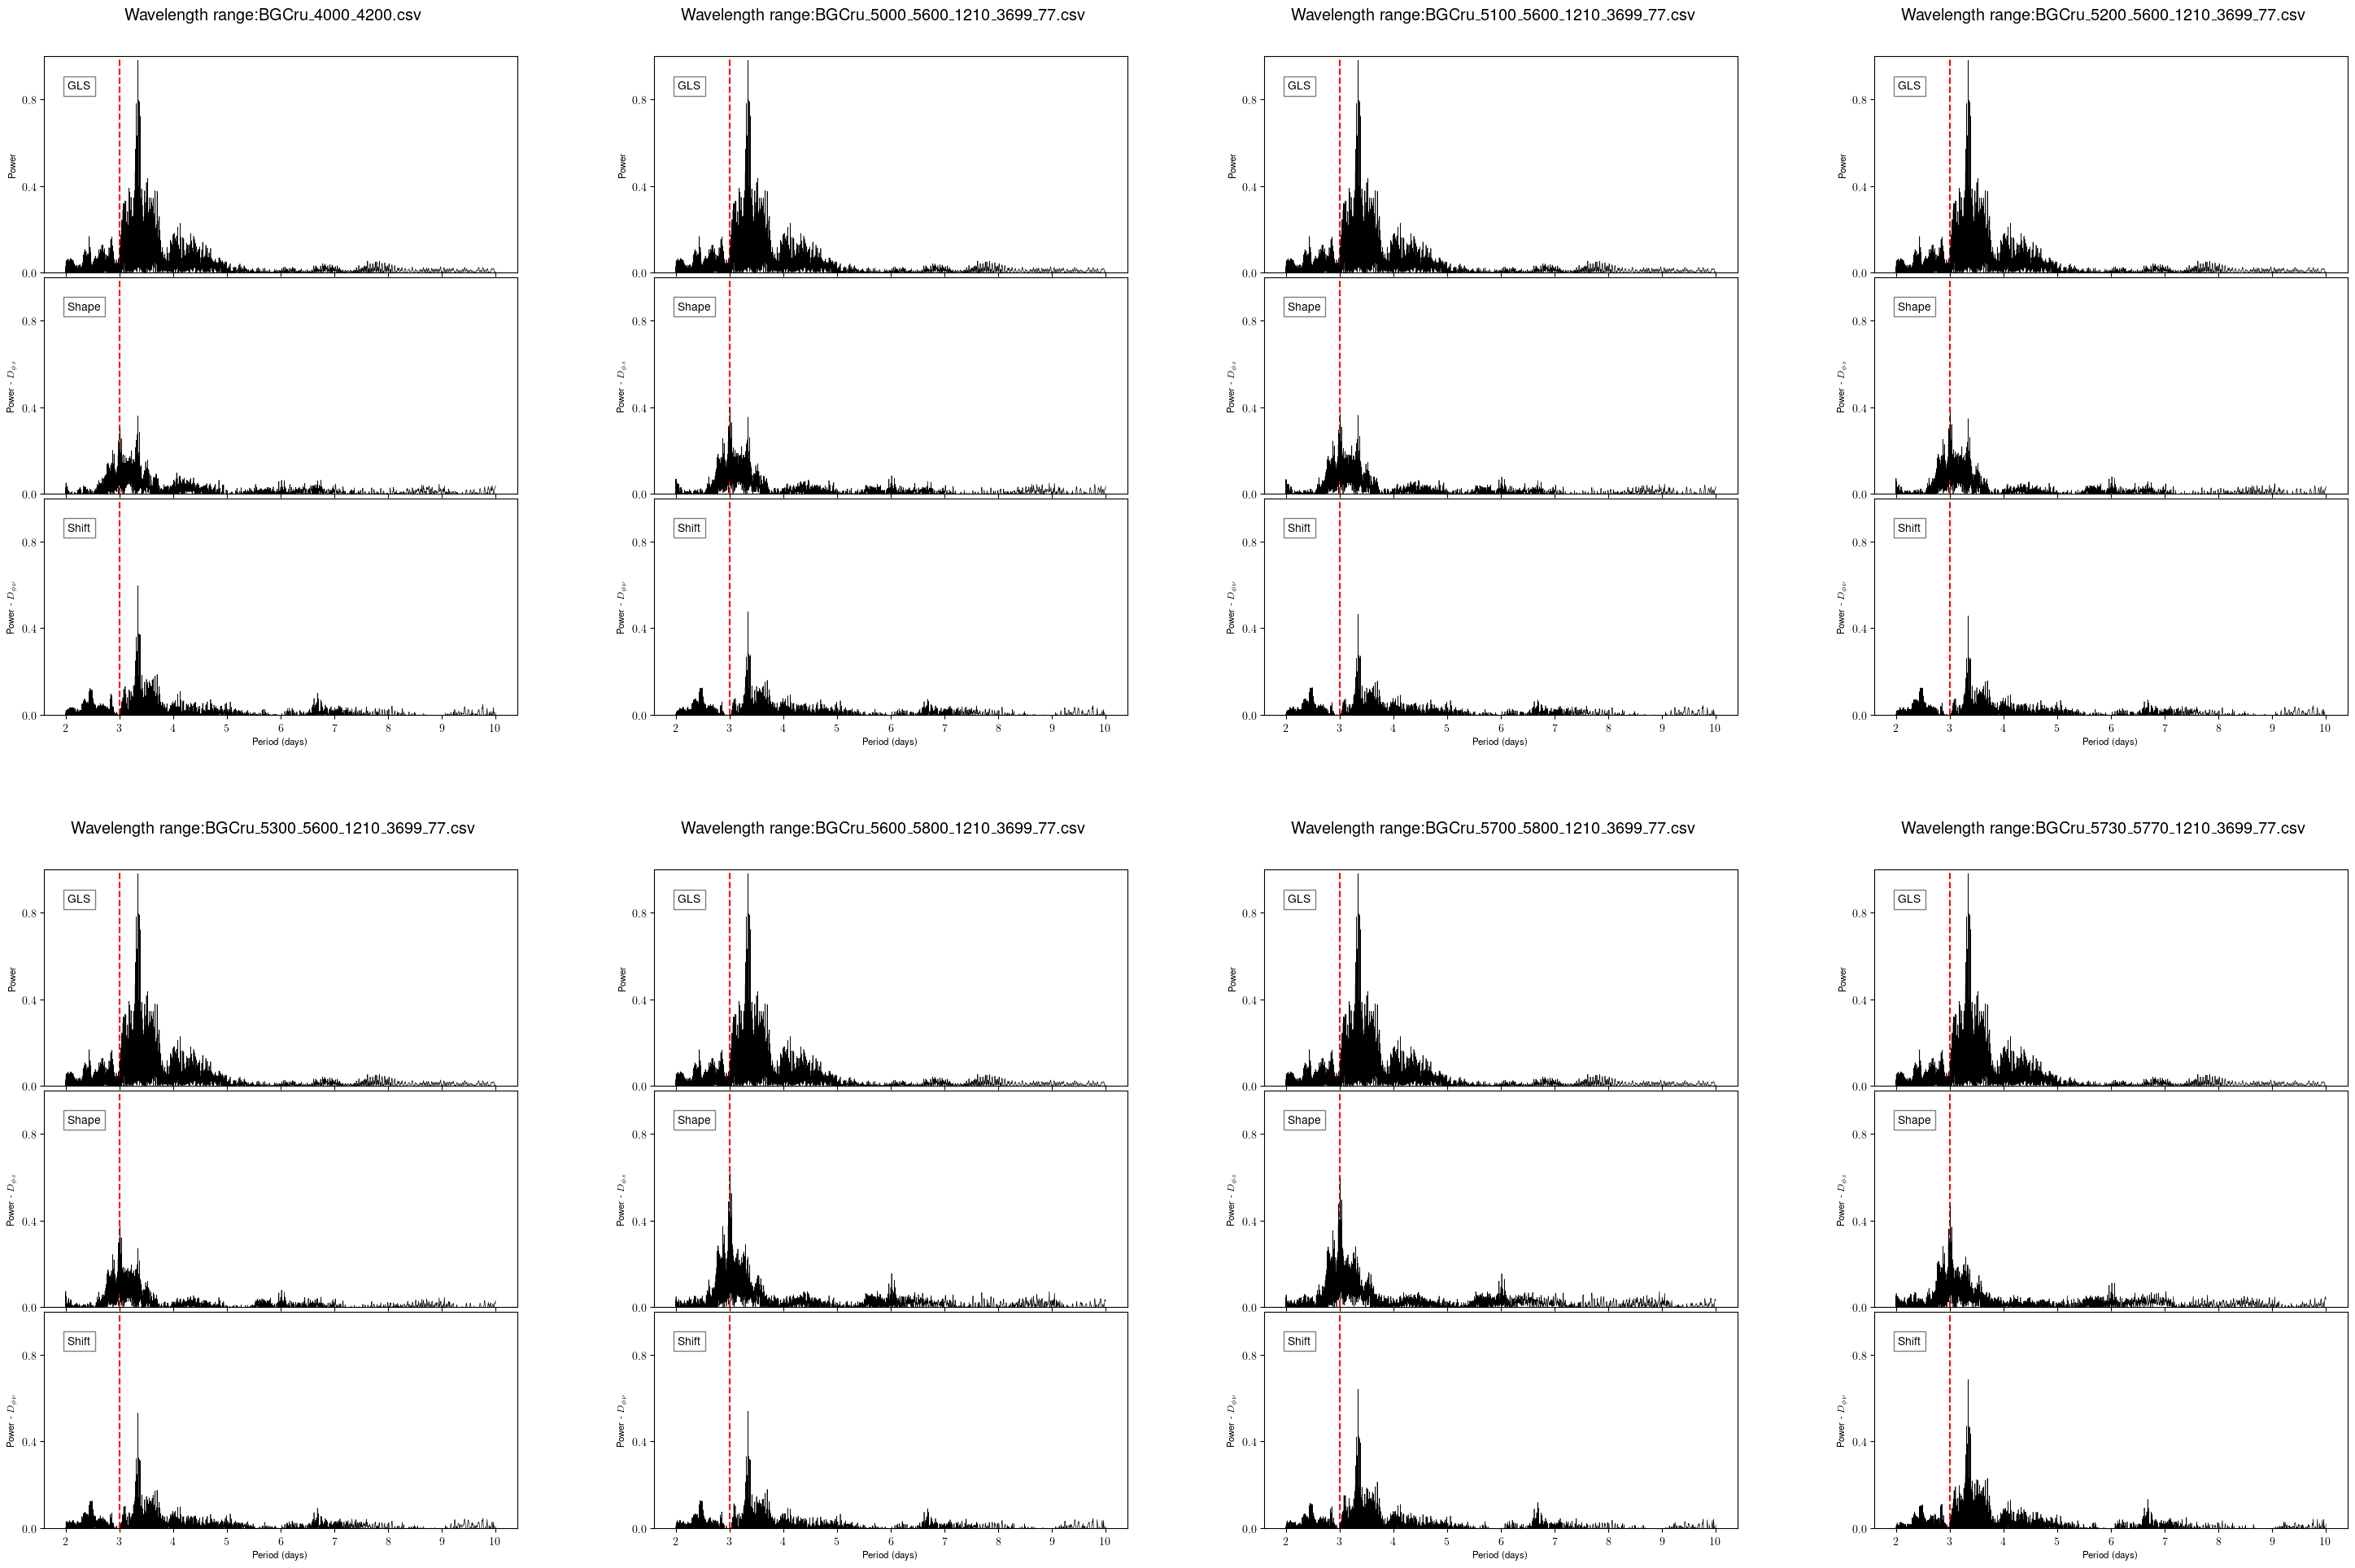

In [83]:
fig = plt.figure(constrained_layout=False, figsize=(30, 20))
fig.suptitle(r'BG Crucis - Looking for the second signal', fontsize='x-large')

# plt.suptitle(r'$\delta$ Cephei - Tellurics Analysis', fontsize='x-large')

subfigs = fig.subfigures(2, 4)

for outerind, subfig in enumerate(subfigs.flat):
    axs = subfig.subplots(3, 1,sharex=True)
    subfig.suptitle(r'Wavelength range:'+filenames[outerind], fontsize='x-large')
    for innerind, ax in enumerate(axs.flat):
        #plot vertical line at 3.00 days
        ax.vlines(3,0,1,ls='--',color='red')
        if innerind==0:
            ax.plot(BGCru_results[outerind]['period'], BGCru_results[outerind]['gls'],linewidth=0.5)
            ax.set_ylabel('Power', fontsize='small')
        elif innerind==1:
            ax.plot(BGCru_results[outerind]['period'], BGCru_results[outerind]['shape'],linewidth=0.5)
            ax.set_ylabel(r'Power - $D_{\phi s}$', fontsize='small')
        elif innerind==2:
            ax.plot(BGCru_results[outerind]['period'],BGCru_results[outerind]['shift'],linewidth=0.5)
            ax.set_ylabel(r'Power - $D_{\phi \nu}$', fontsize='small')
            ax.set_xlabel('Period (days)', fontsize='small')
        # Add a small text box
        text_box = f"{['GLS', 'Shape', 'Shift'][innerind]}"
        ax.text(0.05, 0.85, text_box, transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5))
        ax.set_ylim(0,1)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
plt.subplots_adjust(top=0.92, hspace=0.02, wspace=0.2)
# plt.savefig('delCep_nobs.png', dpi=300)
plt.show()

In [84]:
#fold the times and get the new order of the indices
period_truth = 3.342540
times_folded = [t%period_truth for t in obs_data.time_series.times]
print(obs_data.time_series.times)
print(times_folded)
print(obs_data.time_series.vals)

indices = np.argsort(times_folded).tolist()
obs_data.time_series.times = [obs_data.time_series.times[i] for i in indices]
obs_data.time_series.vals = [obs_data.time_series.vals[i] for i in indices]
print([t%period_truth for t in obs_data.time_series.times])
print(obs_data.time_series.vals)
print(len(obs_data.time_series.vals), len(obs_data.time_series.times),len(times_folded))

[1210.6325059999945, 1210.7231299999985, 1211.6443330000038, 1211.7243210000015, 1212.6317500000005, 1212.7510309999925, 1214.655399000003, 1214.7527120000013, 1215.656458000005, 1215.7475909999994, 1216.6164289999942, 1216.7471440000081, 1218.6186929999967, 1218.7134250000017, 1220.6220990000002, 1220.7284849999996, 1221.6316119999974, 1221.6808119999987, 1532.8010279999944, 1931.5101460000005, 1932.7524690000064, 1934.631570000005, 2243.833667999992, 2244.846832000003, 2245.832955999991, 2247.916551000002, 2248.8256549999933, 2249.797320000005, 2282.7254729999986, 2283.580599000001, 2284.781447000001, 2285.758192999994, 2286.650539999995, 2287.59145, 2288.7684960000042, 2289.7486990000034, 2317.694594000008, 2318.6606580000007, 2319.660342999996, 2320.5867190000063, 2321.6459380000015, 2322.6316039999947, 2326.607339000002, 2327.5137899999972, 2328.613139999994, 2329.5349940000087, 2330.6805779999995, 3417.5477210000026, 3419.659025000001, 3420.7632860000012, 3620.8501620000025, 3627

In [86]:
# Initialize plot
fig, ax = plt.subplots()
# print(len(obs_data.time_series.vals[0].wv[0]), len(obs_data.time_series.vals[0].sp[0]),len(obs_data.time_series.vals))
wavelengths = obs_data.time_series.vals[0].wv[0]
line, = ax.plot(wavelengths, obs_data.time_series.vals[0].sp[0], lw=1, color='k')

# Animation function
def update(frame):
    line.set_xdata(obs_data.time_series.vals[frame].wv[0])
    line.set_ydata(obs_data.time_series.vals[frame].sp[0])
    max_y = np.max(obs_data.time_series.vals[frame].sp[0])
    min_y = np.min(obs_data.time_series.vals[frame].sp[0])
    min_x = 5730
    max_x = 5770
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(-5,5)
    ax.set_xlabel(r'Wavelength $\AA$')
    ax.set_ylabel('Normalized Intensity')
    ax.set_title(r'BG Cru',loc='left',fontsize=8)
    ax.set_title('Phase: ' + str([(t%period_truth)/period_truth for t in obs_data.time_series.times][frame]),loc='right',fontsize=6)
    return line,

# Set animation properties
ani = FuncAnimation(fig, update, frames=len(obs_data.time_series.vals),
                    interval=50, blit=True)

# Enable interactive mode for the notebook
%matplotlib notebook

# Display the animation
HTML(ani.to_jshtml())

# ani.save('BG Cru.gif', writer='pillow', fps=20,dpi=300)

<IPython.core.display.Javascript object>

NameError: name 'min_x' is not defined